## Preparing the data and setting up

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# allow_growth option, which attempts to allocate only as much GPU memory 
# based on runtime allocations: it starts out allocating very little memory, 
# and as Sessions get run and more GPU memory is needed, 
# we extend the GPU memory region needed by the TensorFlow process.
limit_mem()

In [3]:
dpath = os.getcwd() + '/data/'

In [5]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:]

In [7]:
print(arr_lr.shape) # 19439 RGB images with 72x72
print(arr_hr.shape) # 19439 RGB images with 288x288

(19439, 72, 72, 3)
(19439, 288, 288, 3)


In [6]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

## Architecture

In [9]:
# Upgrading the layers to the keras 2.
# Defining all the blocks required for the super resolution network.

def conv_block(x, filters, size, stride=(2,2), padding='same', act=True):
    x = Conv2D(filters, (size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x,ip], mode='sum')

def deconv_block(x, filters, size, stride=(2,2), padding='same'):
    x = Conv2DTranspose(filters, (size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def up_block(x,filters, size, stride=(1,1), padding='same'):
    x = UpSampling2D()(x)
    x = Conv2D(filters,(size,size), strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [11]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, 9, (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Conv2D(3, (9, 9) , activation='tanh', padding='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [43]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [44]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [45]:
inp_shp = arr_hr.shape[1:]

In [46]:
vgg_inp=Input(inp_shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [47]:
for l in vgg.layers: l.trainable=False

In [48]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [49]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [50]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [51]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

In [52]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

In [59]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

In [60]:
top_model = Model(inp, outp)

In [61]:
p = top_model.predict(arr_lr[10:11])

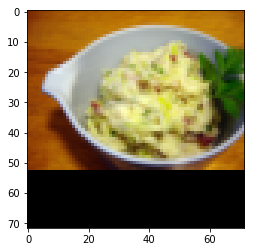

In [56]:
plt.imshow(arr_lr[10].astype('uint8'));

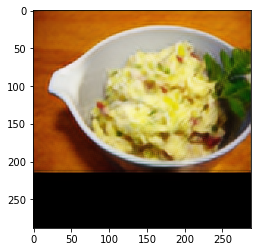

In [58]:
plt.imshow(p[0].astype('uint8')); # After 2 epochs

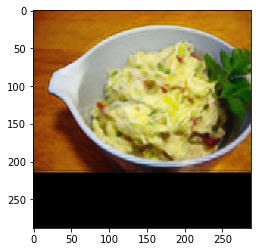

In [62]:
plt.imshow(p[0].astype('uint8')); # After 3 epochs